Grupo A - Integrantes:
- Andrés Jalife
- Benjamin Ortiz
- Franco Schichlo
- Franco Pandolfo
- Lucas Bonfil
- Nicolás Garófalo
- Ramiro Chogri
- Santiago Taddini

Importación de librerías 

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

Definición de directorios

In [3]:
train_dir = 'archive/cropped/train'
test_dir = 'archive/cropped/test'

Definición de train, validation y test set

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator( 
    width_shift_range=0.1,  # Rotaciones horizontales de la imagen (10% de ancho total)
    height_shift_range=0.1,  # Rotaciones verticales de la imagen (10% de alto total)
    rotation_range=40,
    zoom_range = 0.1,
    rescale=1./255,
    validation_split=0.33)
train_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="training"
)
valid_generator = datagen.flow_from_directory(
    directory=train_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=64,
    class_mode="categorical",
    shuffle=True,
    seed=42, 
    subset="validation"
)


test_datagen = ImageDataGenerator(rescale=1./255)
test_generator = test_datagen.flow_from_directory(
    directory=test_dir,
    target_size=(224, 224),
    color_mode="rgb",
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    seed=42
)

Found 8040 images belonging to 120 classes.
Found 3960 images belonging to 120 classes.
Found 8585 images belonging to 120 classes.


Optimizador

In [5]:
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau

optimizer = optimizers.RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

In [7]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)

Importo el modelo Xception

In [9]:
#Modelo Xception
from tensorflow.keras.applications.xception import Xception

STEP_SIZE_TRAIN=train_generator.n//train_generator.batch_size
STEP_SIZE_VALID=valid_generator.n//valid_generator.batch_size
base_model = Xception(weights='imagenet', include_top=False)

83689472/83683744 [==============================] - 55s 1us/step


Agrego capas extras y defino el modelo final

In [15]:
from tensorflow.keras.models import Model
x = base_model.output
x = layers.GlobalAveragePooling2D()(x)
# Capa densa
x = layers.Dense(1024, activation='relu')(x)
# Capa output 
predictions = layers.Dense(120, activation='softmax')(x)

for layer in base_model.layers:
    layer.trainable = False
    

xception = Model(inputs=base_model.input, outputs=predictions)
xception.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

Entreno el modelo final

In [16]:
xception.fit(generator=train_generator,
                    steps_per_epoch=STEP_SIZE_TRAIN,
                    validation_data=valid_generator,
                    validation_steps=STEP_SIZE_VALID,
                    epochs=10,
                    verbose=1,
                    callbacks=[learning_rate_reduction]
)

C:\Users\Nico\AppData\Roaming\Python\Python37\site-packages\tensorflow\python\keras\engine\training.py:1844: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  warnings.warn('`Model.fit_generator` is deprecated and '


Epoch 1/10
125/125 [==============================] - 934s 7s/step - loss: 2.0782 - accuracy: 0.5229 - val_loss: 0.9376 - val_accuracy: 0.7275
Epoch 2/10
125/125 [==============================] - 892s 7s/step - loss: 0.7727 - accuracy: 0.7726 - val_loss: 0.8476 - val_accuracy: 0.7426
Epoch 3/10
125/125 [==============================] - 831s 7s/step - loss: 0.6818 - accuracy: 0.7885 - val_loss: 0.9000 - val_accuracy: 0.7339
Epoch 4/10
125/125 [==============================] - 829s 7s/step - loss: 0.5830 - accuracy: 0.8138 - val_loss: 0.8717 - val_accuracy: 0.7480
Epoch 5/10
125/125 [==============================] - 934s 7s/step - loss: 0.5493 - accuracy: 0.8220 - val_loss: 0.8517 - val_accuracy: 0.7579
Epoch 6/10
125/125 [==============================] - 948s 8s/step - loss: 0.5232 - accuracy: 0.8312 - val_loss: 0.8901 - val_accuracy: 0.7590
Epoch 7/10
125/125 [==============================] - 924s 7s/step - loss: 0.4566 - accuracy: 0.8508 - val_loss: 0.8701 - val_accuracy: 0.7582

Evalúo la red con el test set. Se obtiene 85% accuracy

In [24]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
loss, acc = xception.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST, verbose=0)
print(loss, acc)

0.5536444187164307 0.8506296873092651


Guardo el modelo entrenado en el disco

In [ ]:
xception_model_json = xception.to_json()
with open("xcept_model.json", "w") as json_file:
    json_file.write(xception_model_json)
# guardo los pesos
xception.save_weights("weight_model.h5")
print("Guardado a disco")

Si se descargó el modelo y los pesos, correr la siguiente celda. Es para cargar el modelo entrenado 

In [ ]:
from tensorflow.keras.models import model_from_json
json_file = open('xcept_model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
xception_model = model_from_json(loaded_model_json)
# Cargo pesos
xception_model.load_weights("weight_model.h5")
#Compilo
xception_model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])
print("Cargado desde disco")

Evaluacion del modelo cargado. Elegir entre evaluar o predecir (el predecir está mas abajo)

In [ ]:
score = xception_model.evaluate(test_generator, steps=STEP_SIZE_TEST, verbose=0)
print("%s: %.2f%%" % (xception_model.metrics_names[1], score[1]*100))

Estructura completa del modelo (Incluye las capas del Xception)

In [ ]:
xception_model.summary()

Para predecir el modelo

In [9]:
STEP_SIZE_TEST=test_generator.n//test_generator.batch_size
predictions = xception_model.predict(test_generator,steps = STEP_SIZE_TEST, verbose = 0)

Guardo las predicciones en un array

In [10]:
y_classes = predictions.argmax(axis=-1)
y_classes

array([  0,   0,   0, ..., 119, 119, 119], dtype=int64)

Defino test_ds de nuevo para obtener los nombres de las clases y guardarlo en Breeds

In [11]:
#Creo test_ds solamente para tener las classnames
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_dir)
breeds = test_ds.class_names

Found 8585 files belonging to 120 classes.


Guardo las predicciones en una lista

In [12]:
results_by_class = []
count = 0
for pred in y_classes:
    results_by_class.append((breeds[pred],count))
    count+=1

In [ ]:
#Las predicciones
results_by_class

Creo un array con todos los nombres de las fotos y en qué carpeta están para recrear el directorio y cargar la imagen más abajo

In [13]:
import os
os.listdir("archive/cropped/test")
all_filenames = []
for breed in breeds:
    pictures = os.listdir("archive/cropped/test/" + breed)
    for pic in pictures:
        all_filenames.append((pic,breed))

In [ ]:
all_filenames

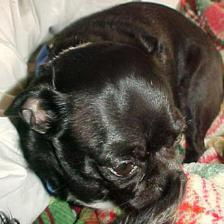

In [136]:
from IPython.display import Image
pos_selected = 40
Image(filename= 'archive/cropped/test/'+ all_filenames[pos_selected][1] + '/'+all_filenames[pos_selected][0]) 

In [137]:
print("Predicción: " + results_by_class[pos_selected][0] + "\nRaza Verdadera: " + all_filenames[pos_selected][1])

Predicción: n02110958-pug
Raza Verdadera: n02085620-Chihuahua
